110.0


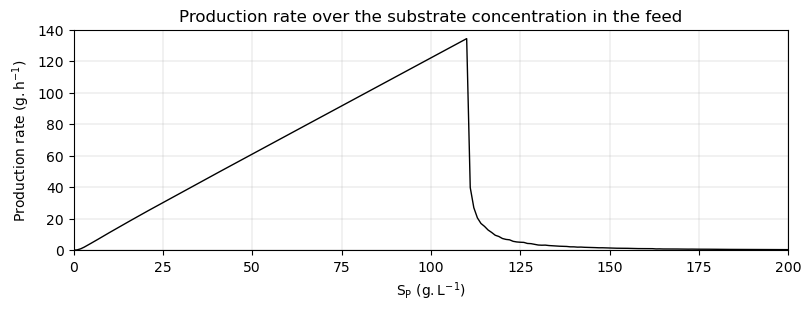

In [51]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8, 3]
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams.update({'font.size': 10})

# Constants
mu_max = 0.3 # 1/h
Ks = 0.8 # g/L
Ki = 100 # g/L
Yxs = 0.45
Yxp = 0.15
Fi = 0.2 # L/h
Fp = 0.5 # L/h
Fh = 2.5 # L/h
ti = 1 # h
tp = 5 # h
th = 1 # h
t_cycle = tp + th # h
S0 = 80 # g/L

def prod_rate_calc(Sp):
    def model(t, y):
        NS, NX, NP, V = y

        mu_net = mu_max*(NS/V)/(Ks + (NS/V)*(1 + (NS/V)/Ki))

        if t < ti:
            dNSdt = Fi*S0 - mu_net*NX/Yxs
            dNXdt = mu_net*NX
            dNPdt = mu_net*NX/Yxp
            dVdt = Fi

        elif (t - 1) % t_cycle < tp:
            dNSdt = Fp*Sp - mu_net*NX/Yxs
            dNXdt = mu_net*NX
            dNPdt = mu_net*NX/Yxp
            dVdt = Fp

        else:
            dNSdt = -Fh*NS/V - mu_net*NX/Yxs
            dNXdt = -Fh*NX/V + mu_net*NX
            dNPdt = -Fh*NP/V + mu_net*NX/Yxp
            dVdt = -Fh

        return [dNSdt, dNXdt, dNPdt, dVdt]
                
    # Initial conditions
    y0 = [0, 30*0.85, 0, 0.85]
    t_span = [0, 1 + 10*t_cycle]

    # Solve ODE
    sol = solve_ivp(model, t_span, y0, method = "Radau", t_eval=np.linspace(0, 1 + 10*t_cycle, 1000), max_step = (1 + 10*t_cycle)/1000)

    t = sol.t
    NS, NX, NP, V = sol.y

    t_harv = 1 + 9*t_cycle + tp
    NP_harv = NP[t >= t_harv]
    V_harv = V[t >= t_harv]

    P_harv = np.trapz(Fh*NP_harv/V_harv, t[t >= t_harv])

    prod_rate = P_harv/(t_cycle)

    return prod_rate

Sp = np.linspace(0, 200, 201)
prod_rate = np.zeros_like(Sp)
for i, sp in enumerate(Sp):
    prod_rate[i] = prod_rate_calc(sp)

max_index = np.argmax(prod_rate)
max_sp = Sp[max_index]

print(max_sp)

ax = plt.subplot(111)
ax.plot(Sp, prod_rate, linewidth = 1.0, color = "black")
ax.set_xlabel(r"$\mathregular{S_P}$ ($\mathregular{g.L^{-1}}$)")
ax.set_ylabel(r"Production rate ($\mathregular{g.h^{-1}}$)")
ax.set_xlim(0, 200)
ax.set_ylim(0, 140)
ax.set_yticks(np.linspace(0, 140, 8))
ax.grid(linewidth = 0.25)

plt.title("Production rate over the substrate concentration in the feed")
plt.savefig("Images\\2.1.eps", format = "eps")
plt.show()